In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

In [2]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

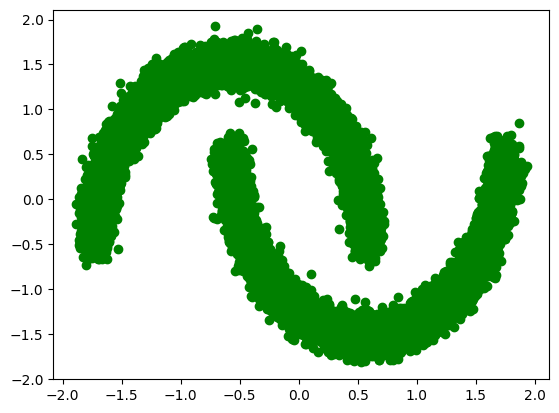

In [3]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

We will build a RealNVP model that can generate points in 2D that follow a similar
distribution to the two moons dataset. Whilst this is a very simple example, it will
help us understand how a normalizing flow model works in practice, in fine detail.

# Coupling layer

A coupling layer produces a scale and translation factor for each element of its input.
In other words, it produces two tensors that are exactly the same size as the input,
one for the scale factor and one for the translation factor

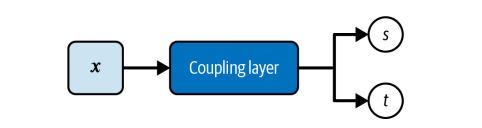

To build a custom Coupling layer for our simple example, we can stack Dense layers
to create the scale output and a different set of Dense layers to create the translation
output

Linear Activation Function:

The linear activation function is quite straightforward. It's simply
f(x)=x, where the output is directly proportional to the input.


Unlike other activation functions like sigmoid or tanh, the linear activation function doesn't introduce non-linearity to the network.


It's commonly used in the output layer of regression models where the network needs to predict continuous values.


In hidden layers, using a linear activation function would result in a network that's essentially just performing linear transformations, hence non-linear activation functions like ReLU or tanh are preferred for hidden layers to introduce non-linearity and enable the network to learn complex patterns.

In [4]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

# Passing Data through a coupling layer

The architecture of a coupling layer is not particularly interesting—what makes it
unique is the way the input data is masked and transformed as it is fed through the
layer.

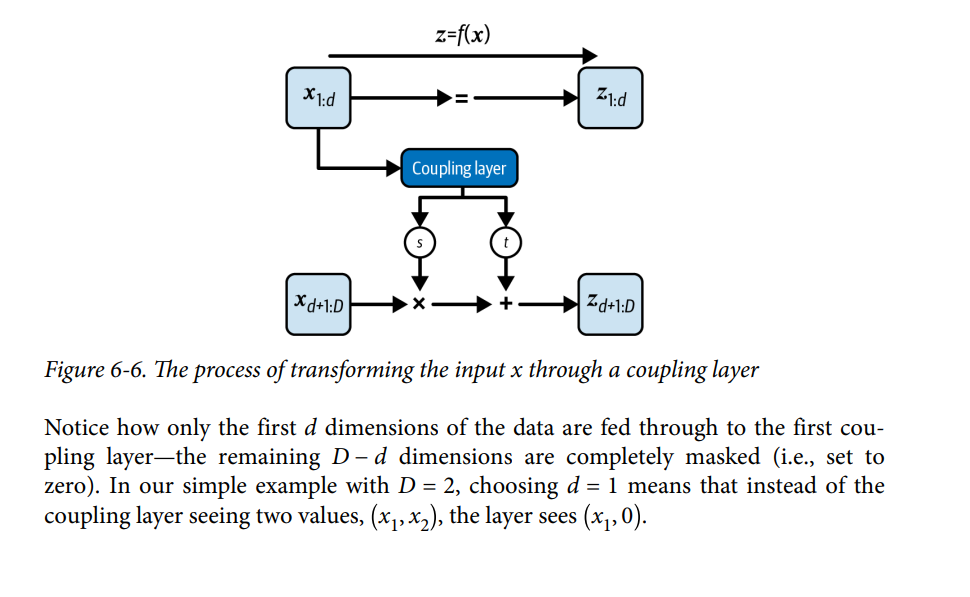

If we stack coupling layers
on top of each other but alternate the masking pattern, the layers that are left
unchanged by one layer will be updated in the next. This architecture has the added
benefit of being able to learn more complex representations of the data, as it is a
deeper neural network.


The Jacobian of this composition of coupling layers will still be simple to compute,
because linear algebra tells us that the determinant of a matrix product is the product
of the determinants. Similarly, the inverse of the composition of two functions is just
the composition of the inverses, as shown in the following equations.

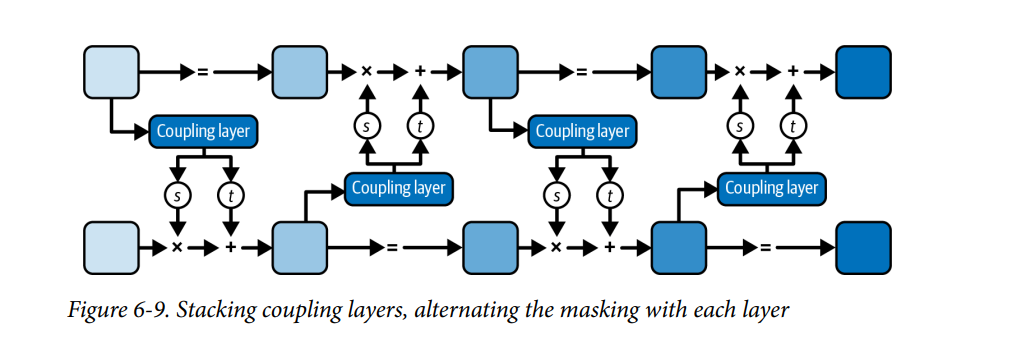

# Training the RealNVP model

Remember, we want to minimize the negative
log-likelihood of the data under the model

Negative log-likelihood is commonly used as a loss function in probabilistic modeling, including in the training of generative models like RealNVP, for several reasons:

**Positive Values:** Likelihood values themselves are typically between 0 and 1. By taking the negative logarithm, we convert them to positive values, making it more intuitive to interpret the loss.

**Convexity:**Negative log-likelihood is a convex function. This property is beneficial because it ensures that optimization algorithms, such as gradient descent, converge reliably towards a global minimum rather than getting stuck in local minima.

**Probabilistic Interpretation:** Negative log-likelihood can be interpreted as the amount of surprise or the discrepancy between the model's predictions and the actual data. Minimizing negative log-likelihood effectively maximizes the likelihood of observing the training data under the model, aligning with the goal of probabilistic modeling.

**Mathematical Convenience:** Logarithms simplify calculations, especially when dealing with products of probabilities. Taking the logarithm of the likelihood allows us to convert multiplications into additions, which can be computationally more efficient.

In summary, negative log-likelihood is a natural choice as a loss function in probabilistic modeling because of its mathematical properties, interpretability, and alignment with the goal of maximizing the likelihood of the observed data under the model.

We choose the target output distribution pZz of the forward process f to be a standard Gaussian, because we can easily sample from this distribution. We can then
transform a point sampled from the Gaussian back into the original image domain by
applying the inverse process g

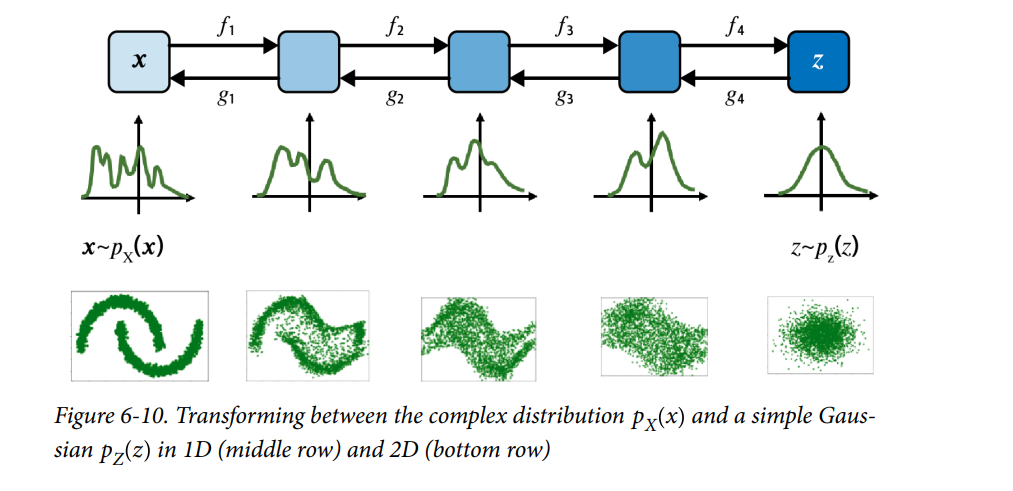

In [10]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        ) # The target distribution is a standard 2D Gaussian

        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        ) # Here, we create the alternating mask pattern.

        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ] # A list of Coupling layers that define the RealNVP network.

    @property
    def metrics(self):
        return [self.loss_tracker]

    # In the main call function of the network, we loop over the Coupling layers. If training=True, then we move forward through the layers (i.e., from data to
      # latent space). If training=False, then we move backward through the layers (i.e., from latent space to data).

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet # The loss function is the negative sum of the log probability of the transformed data, under our target Gaussian distribution and the log determinant of the Jacobian.
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

In [12]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [15]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples
            )


img_generator_callback = ImageGenerator(num_samples=3000)

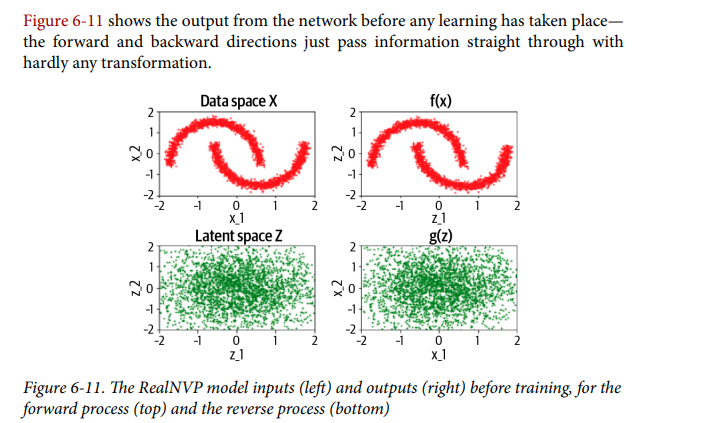

Epoch 1/300
118/118 [==============================] - ETA: 0s - loss: 2.3196

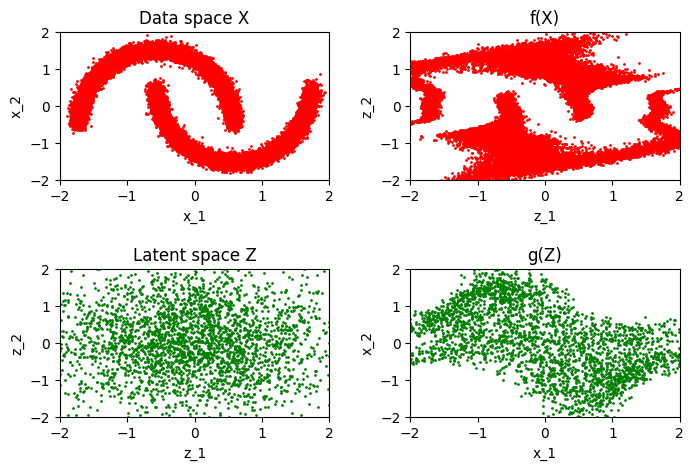

118/118 [==============================] - 2s 21ms/step - loss: 2.3196
Epoch 2/300
118/118 [==============================] - 2s 14ms/step - loss: 2.1692
Epoch 3/300
118/118 [==============================] - 1s 9ms/step - loss: 2.0824
Epoch 4/300
118/118 [==============================] - 1s 9ms/step - loss: 2.0290
Epoch 5/300
118/118 [==============================] - 1s 10ms/step - loss: 1.9744
Epoch 6/300
118/118 [==============================] - 1s 10ms/step - loss: 1.9024
Epoch 7/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7898
Epoch 8/300
118/118 [==============================] - 1s 9ms/step - loss: 1.7624
Epoch 9/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7492
Epoch 10/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7527
Epoch 11/300
118/118 [==============================] - ETA: 0s - loss: 1.7421

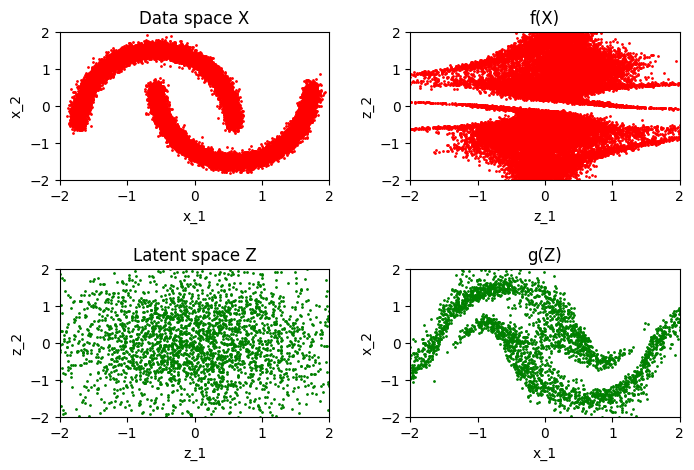

118/118 [==============================] - 4s 34ms/step - loss: 1.7421
Epoch 12/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7343
Epoch 13/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7351
Epoch 14/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7294
Epoch 15/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7243
Epoch 16/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7280
Epoch 17/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7251
Epoch 18/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7273
Epoch 19/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7206
Epoch 20/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7270
Epoch 21/300
113/118 [===========================>..] - ETA: 0s - loss: 1.7234

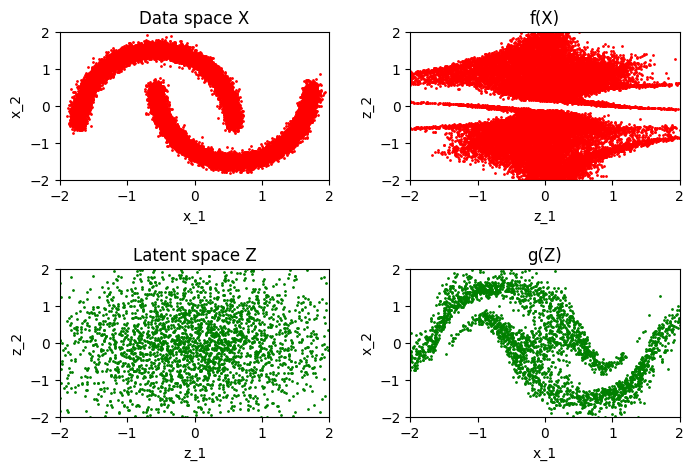

118/118 [==============================] - 2s 20ms/step - loss: 1.7228
Epoch 22/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7199
Epoch 23/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7235
Epoch 24/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7317
Epoch 25/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7158
Epoch 26/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7180
Epoch 27/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7159
Epoch 28/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7387
Epoch 29/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7194
Epoch 30/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7220
Epoch 31/300
118/118 [==============================] - ETA: 0s - loss: 1.7154

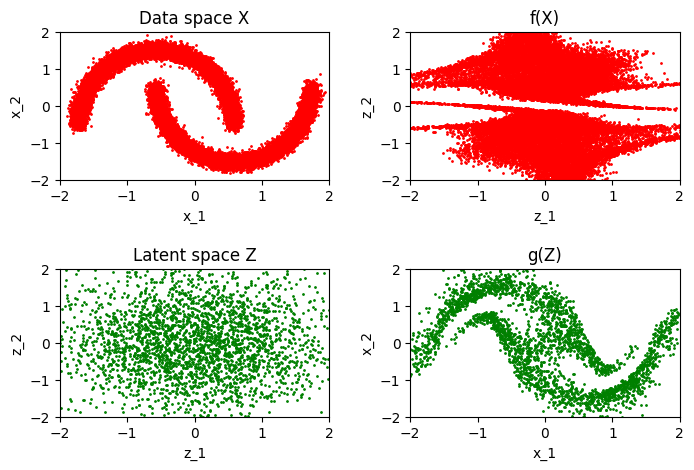

118/118 [==============================] - 2s 19ms/step - loss: 1.7154
Epoch 32/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7166
Epoch 33/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7151
Epoch 34/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7213
Epoch 35/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7172
Epoch 36/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7108
Epoch 37/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7366
Epoch 38/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7189
Epoch 39/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7115
Epoch 40/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7147
Epoch 41/300
117/118 [============================>.] - ETA: 0s - loss: 1.7132

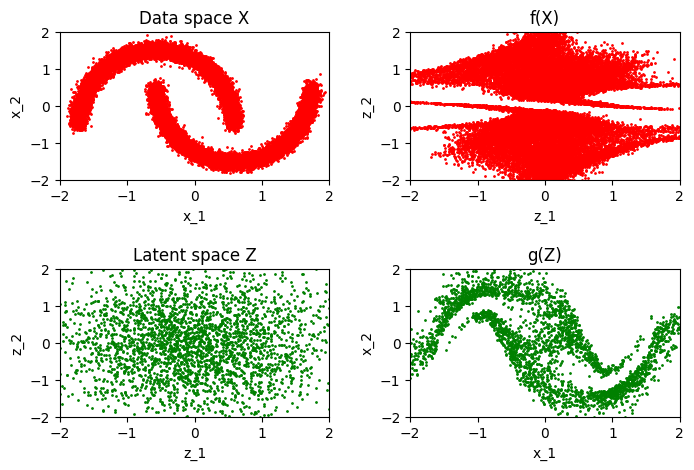

118/118 [==============================] - 2s 20ms/step - loss: 1.7115
Epoch 42/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7089
Epoch 43/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7122
Epoch 44/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7173
Epoch 45/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7083
Epoch 46/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7144
Epoch 47/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7085
Epoch 48/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7148
Epoch 49/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7118
Epoch 50/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7115
Epoch 51/300
115/118 [============================>.] - ETA: 0s - loss: 1.7112

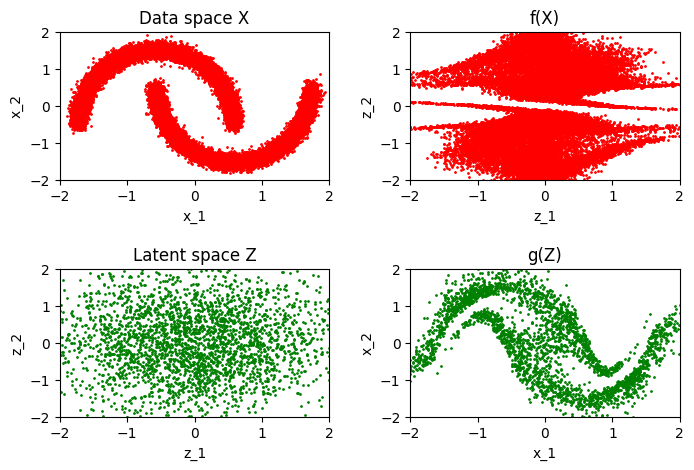

118/118 [==============================] - 2s 20ms/step - loss: 1.7113
Epoch 52/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7074
Epoch 53/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7076
Epoch 54/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7106
Epoch 55/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7147
Epoch 56/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7127
Epoch 57/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7109
Epoch 58/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7124
Epoch 59/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7109
Epoch 60/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7095
Epoch 61/300
116/118 [============================>.] - ETA: 0s - loss: 1.7102

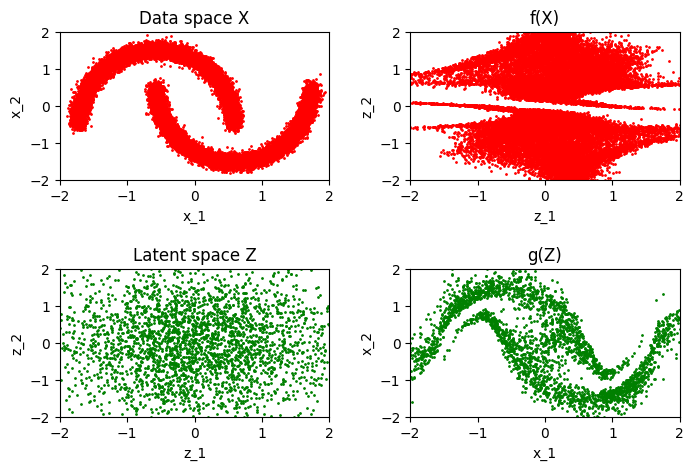

118/118 [==============================] - 2s 19ms/step - loss: 1.7102
Epoch 62/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7110
Epoch 63/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7070
Epoch 64/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7101
Epoch 65/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7078
Epoch 66/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7104
Epoch 67/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7046
Epoch 68/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7096
Epoch 69/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7109
Epoch 70/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7114
Epoch 71/300
115/118 [============================>.] - ETA: 0s - loss: 1.7070

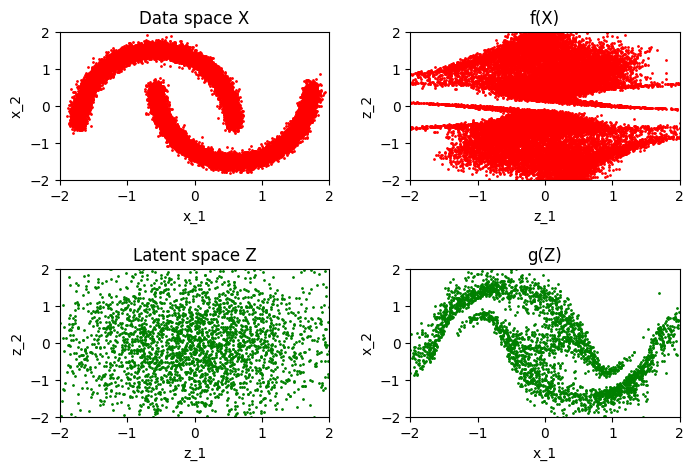

118/118 [==============================] - 3s 21ms/step - loss: 1.7059
Epoch 72/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7097
Epoch 73/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7094
Epoch 74/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7096
Epoch 75/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7101
Epoch 76/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7131
Epoch 77/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7080
Epoch 78/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7044
Epoch 79/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7097
Epoch 80/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7097
Epoch 81/300
115/118 [============================>.] - ETA: 0s - loss: 1.7100

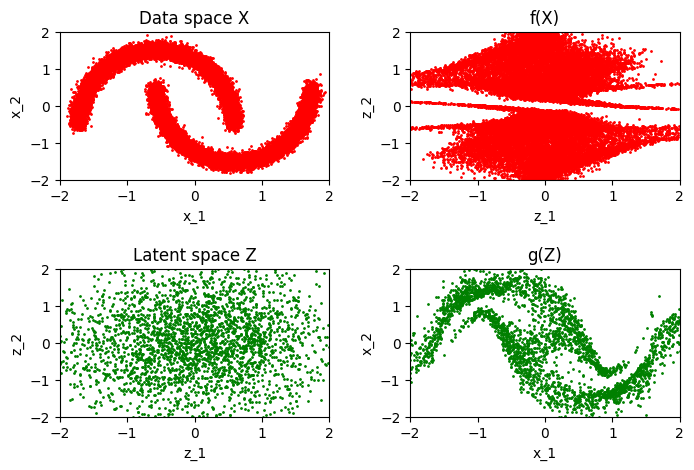

118/118 [==============================] - 3s 26ms/step - loss: 1.7092
Epoch 82/300
118/118 [==============================] - 1s 10ms/step - loss: 1.7122
Epoch 83/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7103
Epoch 84/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7081
Epoch 85/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7177
Epoch 86/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7064
Epoch 87/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7055
Epoch 88/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7134
Epoch 89/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7089
Epoch 90/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7058
Epoch 91/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7069

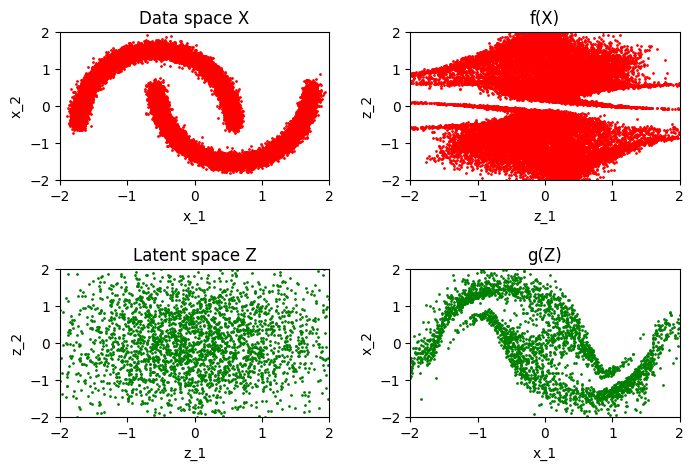

118/118 [==============================] - 2s 21ms/step - loss: 1.7088
Epoch 92/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7062
Epoch 93/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7063
Epoch 94/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7088
Epoch 95/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7097
Epoch 96/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7066
Epoch 97/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7094
Epoch 98/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7153
Epoch 99/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7049
Epoch 100/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7036
Epoch 101/300
118/118 [==============================] - ETA: 0s - loss: 1.7093

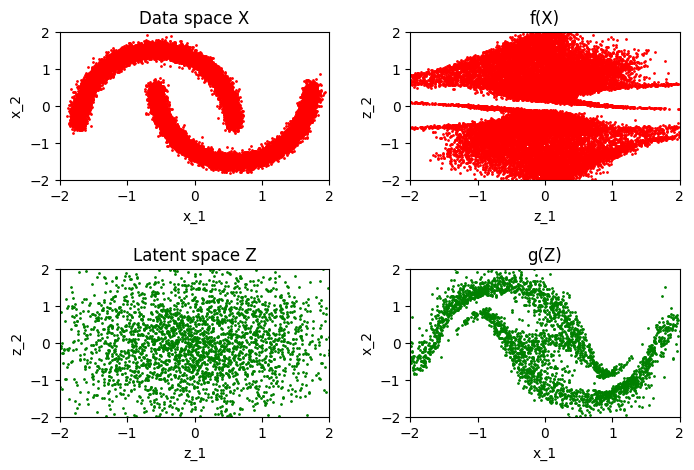

118/118 [==============================] - 2s 21ms/step - loss: 1.7093
Epoch 102/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7119
Epoch 103/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7119
Epoch 104/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7098
Epoch 105/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7064
Epoch 106/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7056
Epoch 107/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7042
Epoch 108/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7090
Epoch 109/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7060
Epoch 110/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7051
Epoch 111/300
116/118 [============================>.] - ETA: 0s - loss: 1.7062

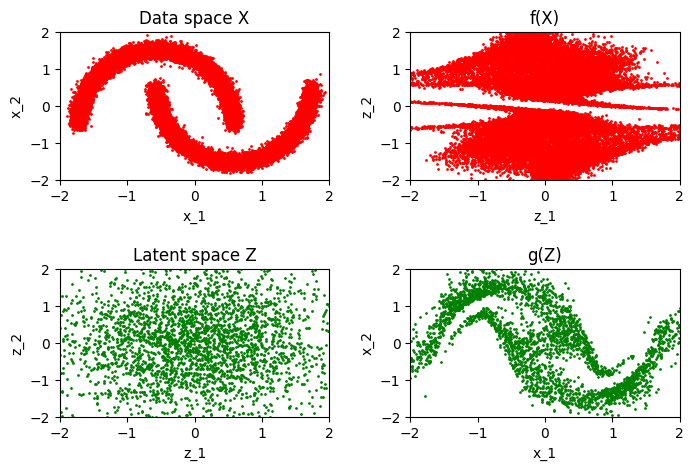

118/118 [==============================] - 2s 20ms/step - loss: 1.7060
Epoch 112/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7040
Epoch 113/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7052
Epoch 114/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7066
Epoch 115/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7074
Epoch 116/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7085
Epoch 117/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7045
Epoch 118/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7067
Epoch 119/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7054
Epoch 120/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7045
Epoch 121/300
118/118 [==============================] - ETA: 0s - loss: 1.7021

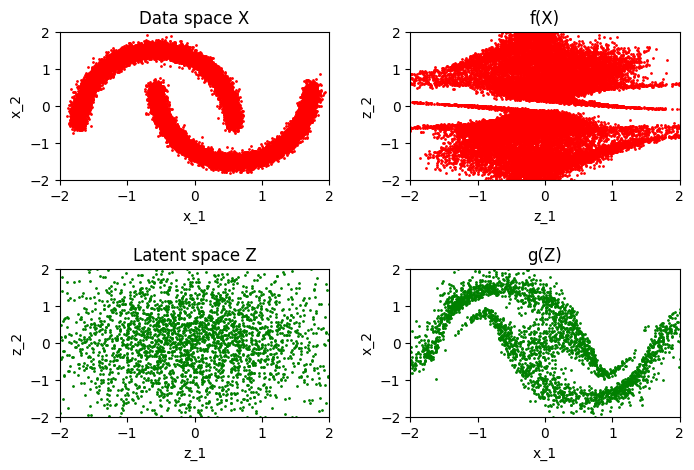

118/118 [==============================] - 2s 21ms/step - loss: 1.7021
Epoch 122/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7065
Epoch 123/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7105
Epoch 124/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7096
Epoch 125/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7038
Epoch 126/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7057
Epoch 127/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7102
Epoch 128/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7055
Epoch 129/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7031
Epoch 130/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7084
Epoch 131/300
117/118 [============================>.] - ETA: 0s - loss: 1.7014

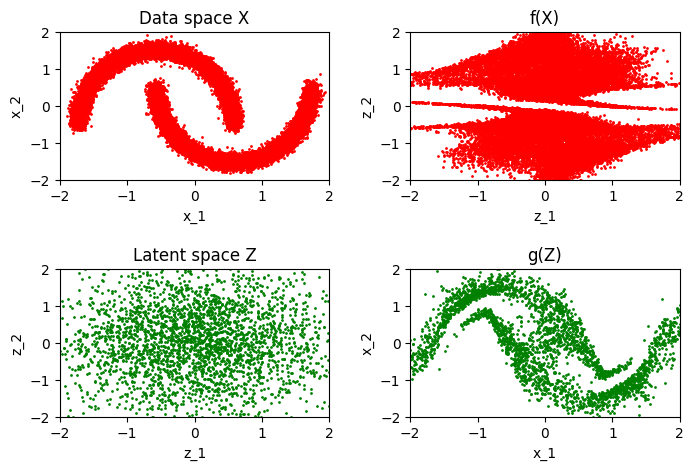

118/118 [==============================] - 3s 24ms/step - loss: 1.7016
Epoch 132/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7049
Epoch 133/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7089
Epoch 134/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7075
Epoch 135/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7031
Epoch 136/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7067
Epoch 137/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7111
Epoch 138/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7027
Epoch 139/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7061
Epoch 140/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7118
Epoch 141/300
116/118 [============================>.] - ETA: 0s - loss: 1.7056

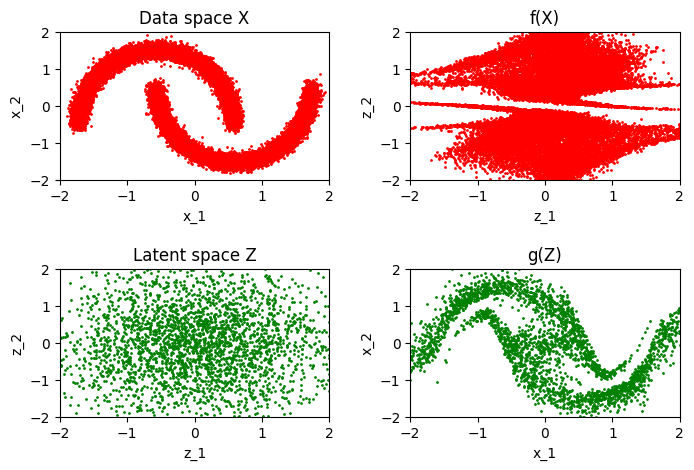

118/118 [==============================] - 3s 25ms/step - loss: 1.7058
Epoch 142/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7116
Epoch 143/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7044
Epoch 144/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7050
Epoch 145/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7050
Epoch 146/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7044
Epoch 147/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7043
Epoch 148/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7045
Epoch 149/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7041
Epoch 150/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7061
Epoch 151/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7100

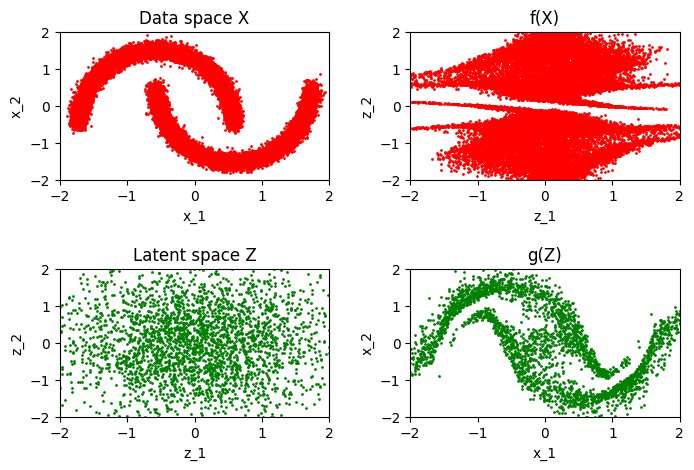

118/118 [==============================] - 2s 21ms/step - loss: 1.7098
Epoch 152/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7077
Epoch 153/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7058
Epoch 154/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7062
Epoch 155/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7056
Epoch 156/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7063
Epoch 157/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7031
Epoch 158/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7046
Epoch 159/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7087
Epoch 160/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7039
Epoch 161/300
116/118 [============================>.] - ETA: 0s - loss: 1.7037

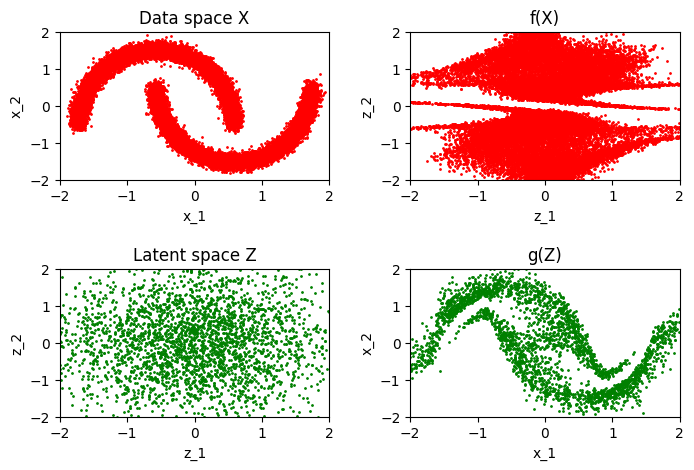

118/118 [==============================] - 2s 20ms/step - loss: 1.7059
Epoch 162/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7042
Epoch 163/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7024
Epoch 164/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7042
Epoch 165/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7084
Epoch 166/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7026
Epoch 167/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7057
Epoch 168/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7046
Epoch 169/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7013
Epoch 170/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7045
Epoch 171/300
117/118 [============================>.] - ETA: 0s - loss: 1.7039

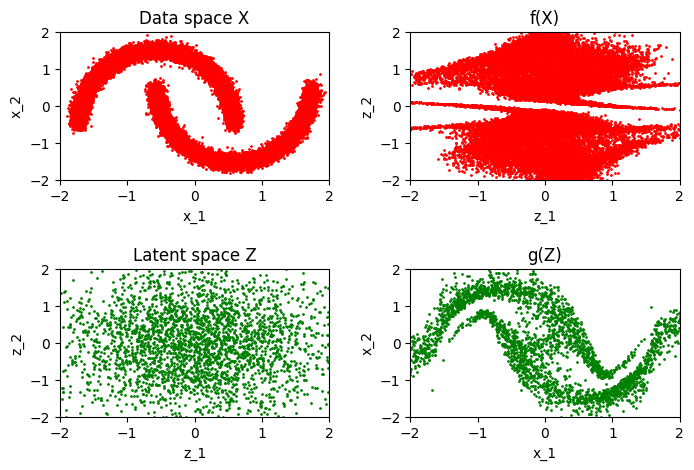

118/118 [==============================] - 2s 21ms/step - loss: 1.7041
Epoch 172/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7018
Epoch 173/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7057
Epoch 174/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7038
Epoch 175/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7062
Epoch 176/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7069
Epoch 177/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7014
Epoch 178/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7086
Epoch 179/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7018
Epoch 180/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7063
Epoch 181/300
117/118 [============================>.] - ETA: 0s - loss: 1.7011

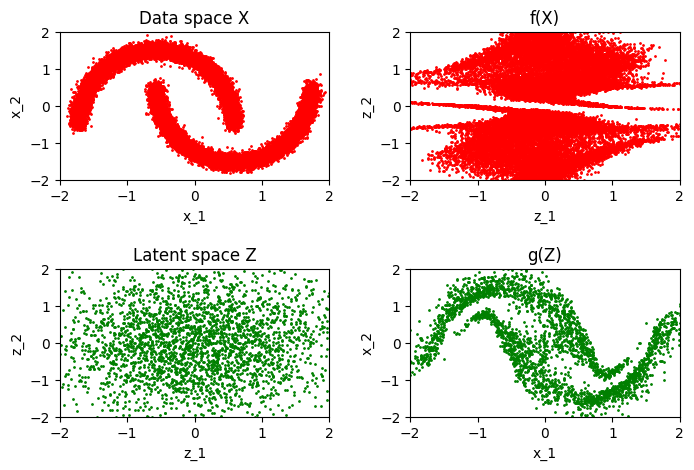

118/118 [==============================] - 3s 28ms/step - loss: 1.7013
Epoch 182/300
118/118 [==============================] - 1s 11ms/step - loss: 1.7056
Epoch 183/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7028
Epoch 184/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7035
Epoch 185/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7025
Epoch 186/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7025
Epoch 187/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7024
Epoch 188/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7060
Epoch 189/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7045
Epoch 190/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7024
Epoch 191/300
114/118 [===========================>..] - ETA: 0s - loss: 1.6990

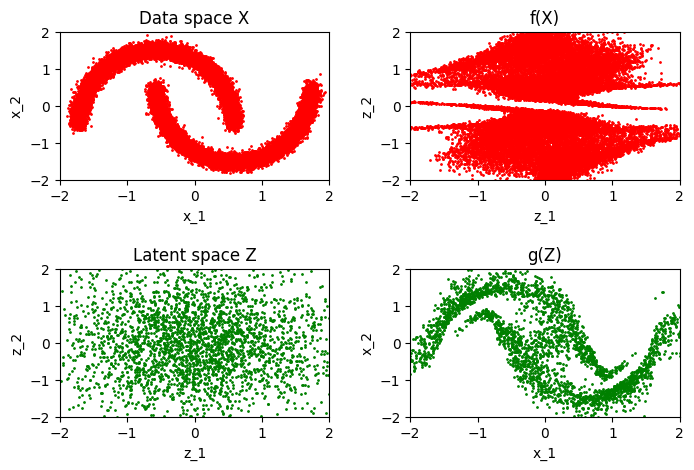

118/118 [==============================] - 2s 21ms/step - loss: 1.6990
Epoch 192/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7027
Epoch 193/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7038
Epoch 194/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7026
Epoch 195/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7042
Epoch 196/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7004
Epoch 197/300
118/118 [==============================] - 3s 26ms/step - loss: 1.7081
Epoch 198/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7003
Epoch 199/300
118/118 [==============================] - 2s 17ms/step - loss: 1.6976
Epoch 200/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7028
Epoch 201/300
117/118 [============================>.] - ETA: 0s - loss: 1.7051

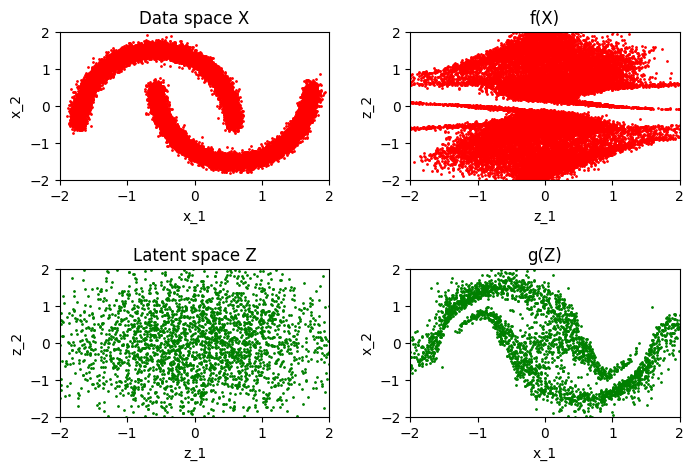

118/118 [==============================] - 3s 21ms/step - loss: 1.7065
Epoch 202/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7055
Epoch 203/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7005
Epoch 204/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7016
Epoch 205/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7045
Epoch 206/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7059
Epoch 207/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7010
Epoch 208/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7011
Epoch 209/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7031
Epoch 210/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7002
Epoch 211/300
116/118 [============================>.] - ETA: 0s - loss: 1.7006

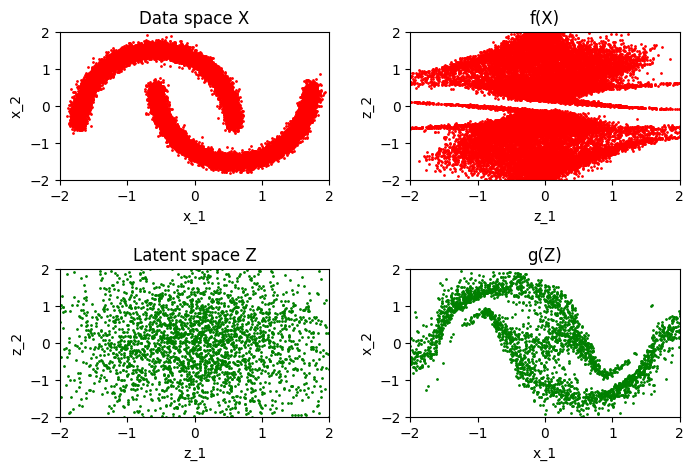

118/118 [==============================] - 3s 28ms/step - loss: 1.7005
Epoch 212/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7064
Epoch 213/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7013
Epoch 214/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7031
Epoch 215/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7026
Epoch 216/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7033
Epoch 217/300
118/118 [==============================] - 1s 13ms/step - loss: 1.6964
Epoch 218/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7034
Epoch 219/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7009
Epoch 220/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7014
Epoch 221/300
117/118 [============================>.] - ETA: 0s - loss: 1.7034

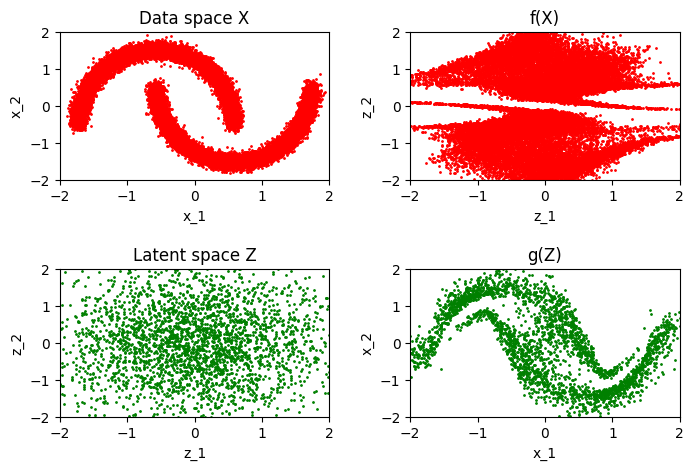

118/118 [==============================] - 3s 21ms/step - loss: 1.7038
Epoch 222/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6993
Epoch 223/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7014
Epoch 224/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7037
Epoch 225/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7019
Epoch 226/300
118/118 [==============================] - 2s 16ms/step - loss: 1.6992
Epoch 227/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7040
Epoch 228/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7020
Epoch 229/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7008
Epoch 230/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7003
Epoch 231/300
118/118 [==============================] - ETA: 0s - loss: 1.6983

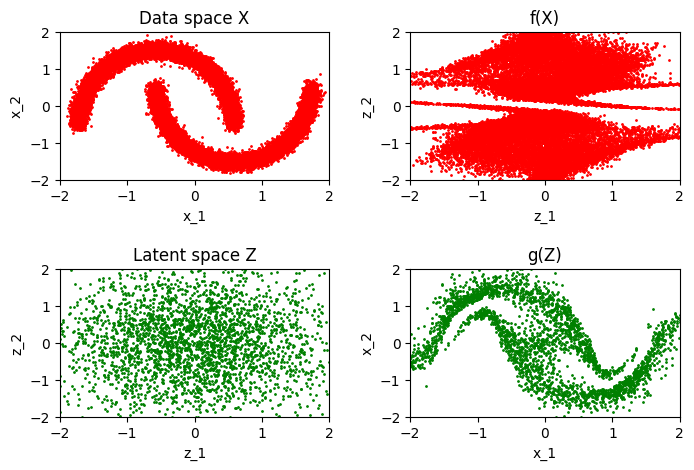

118/118 [==============================] - 3s 21ms/step - loss: 1.6983
Epoch 232/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7001
Epoch 233/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7007
Epoch 234/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7004
Epoch 235/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7023
Epoch 236/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7029
Epoch 237/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7004
Epoch 238/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6978
Epoch 239/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7052
Epoch 240/300
118/118 [==============================] - 1s 12ms/step - loss: 1.7010
Epoch 241/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7046

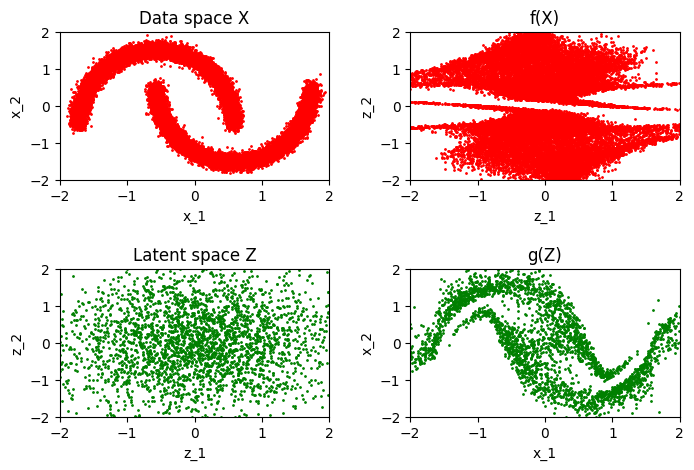

118/118 [==============================] - 3s 21ms/step - loss: 1.7047
Epoch 242/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7052
Epoch 243/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7059
Epoch 244/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7014
Epoch 245/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7026
Epoch 246/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7037
Epoch 247/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6966
Epoch 248/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6996
Epoch 249/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7008
Epoch 250/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7020
Epoch 251/300
116/118 [============================>.] - ETA: 0s - loss: 1.7003

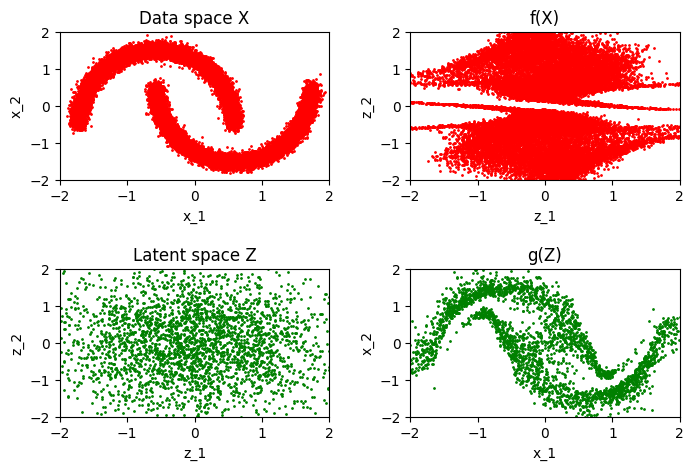

118/118 [==============================] - 4s 31ms/step - loss: 1.6996
Epoch 252/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6988
Epoch 253/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7018
Epoch 254/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7021
Epoch 255/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7029
Epoch 256/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7036
Epoch 257/300
118/118 [==============================] - 2s 15ms/step - loss: 1.6982
Epoch 258/300
118/118 [==============================] - 2s 15ms/step - loss: 1.6988
Epoch 259/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7048
Epoch 260/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7020
Epoch 261/300
118/118 [==============================] - ETA: 0s - loss: 1.6993

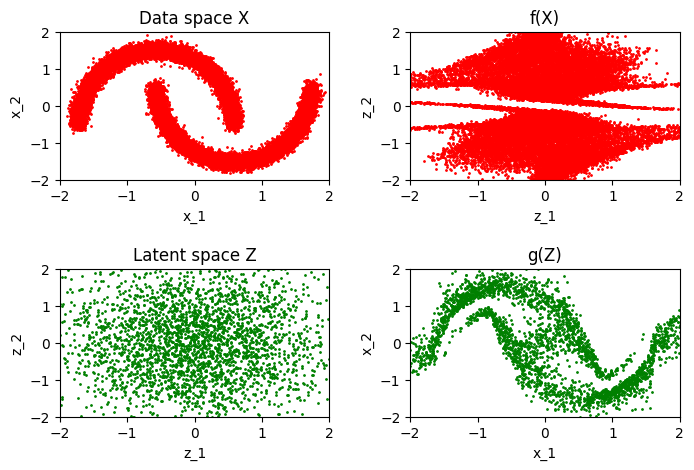

118/118 [==============================] - 3s 23ms/step - loss: 1.6993
Epoch 262/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6985
Epoch 263/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6980
Epoch 264/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6996
Epoch 265/300
118/118 [==============================] - 2s 18ms/step - loss: 1.6971
Epoch 266/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7043
Epoch 267/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7025
Epoch 268/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7019
Epoch 269/300
118/118 [==============================] - 1s 13ms/step - loss: 1.7022
Epoch 270/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6968
Epoch 271/300
115/118 [============================>.] - ETA: 0s - loss: 1.6976

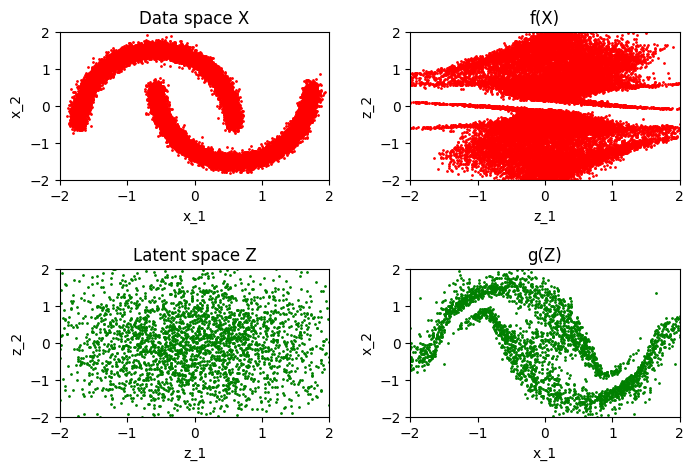

118/118 [==============================] - 3s 22ms/step - loss: 1.6997
Epoch 272/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7007
Epoch 273/300
118/118 [==============================] - 2s 17ms/step - loss: 1.6984
Epoch 274/300
118/118 [==============================] - 2s 16ms/step - loss: 1.7022
Epoch 275/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7011
Epoch 276/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7051
Epoch 277/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6999
Epoch 279/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6980
Epoch 280/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7054
Epoch 281/300
118/118 [==============================] - ETA: 0s - loss: 1.6997

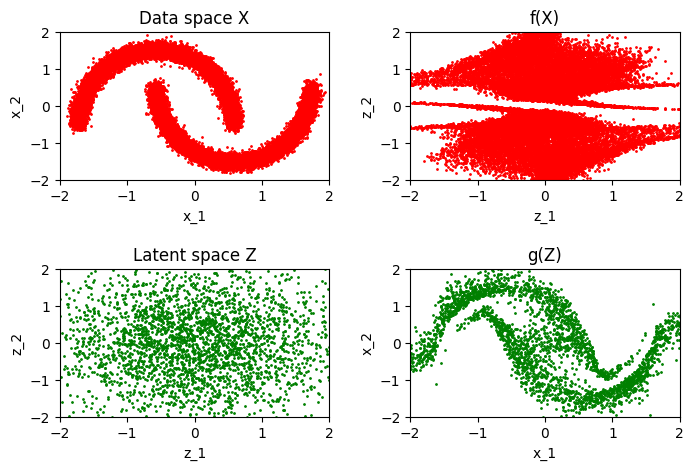

118/118 [==============================] - 4s 30ms/step - loss: 1.6997
Epoch 282/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7004
Epoch 283/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7024
Epoch 284/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6972
Epoch 285/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7033
Epoch 286/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7056
Epoch 287/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7002
Epoch 288/300
118/118 [==============================] - 2s 18ms/step - loss: 1.6957
Epoch 289/300
118/118 [==============================] - 2s 18ms/step - loss: 1.6970
Epoch 290/300
118/118 [==============================] - 2s 14ms/step - loss: 1.6996
Epoch 291/300
117/118 [============================>.] - ETA: 0s - loss: 1.7020

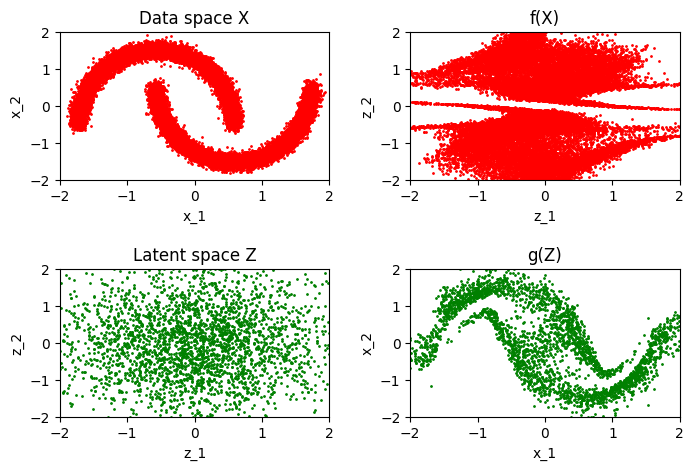

118/118 [==============================] - 3s 26ms/step - loss: 1.7030
Epoch 292/300
118/118 [==============================] - 2s 13ms/step - loss: 1.7047
Epoch 293/300
118/118 [==============================] - 2s 13ms/step - loss: 1.6955
Epoch 294/300
118/118 [==============================] - 2s 14ms/step - loss: 1.6995
Epoch 295/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7009
Epoch 296/300
118/118 [==============================] - 2s 15ms/step - loss: 1.7025
Epoch 297/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7031
Epoch 298/300
118/118 [==============================] - 2s 14ms/step - loss: 1.7013
Epoch 299/300
118/118 [==============================] - 2s 14ms/step - loss: 1.6995
Epoch 300/300
118/118 [==============================] - 2s 14ms/step - loss: 1.6994


In [16]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[img_generator_callback],
)

By design, the scale and translation operations can be easily inverted, so that once the
model is trained it is possible to run data through the network in reverse. This means
that we can target the forward transformation process toward a standard Gaussian,
which we can easily sample from. We can then run the sampled points backward
through the network to generate new observations

# Generate new points

In [17]:
x, z, samples = img_generator_callback.generate()

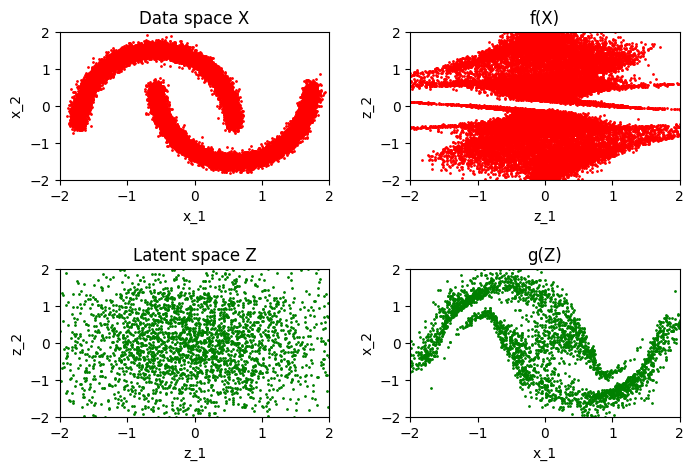

In [18]:
img_generator_callback.display(x, z, samples)